# CODE DESCRIPTION
1. This code takes the label_data from the processed data and builds a model to categorize the rice_type given area
2. and exports the finalized model as finalized_model.pkl

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc , make_scorer , roc_auc_score
import pickle

In [2]:
combined = pd.read_csv('processed_data/label_data.csv',index_col = 0)

In [3]:
combined

,area,rice_type
0,862.5,broken
1,0.0,broken
2,1409.0,broken
3,1516.0,broken
4,1484.5,broken
...,...,...
5973,2012.5,full
5974,516.5,full
5975,1841.0,full
5976,164.5,full


# EDA

<AxesSubplot: title={'center': 'Data distribution'}, xlabel='rice_type', ylabel='area'>

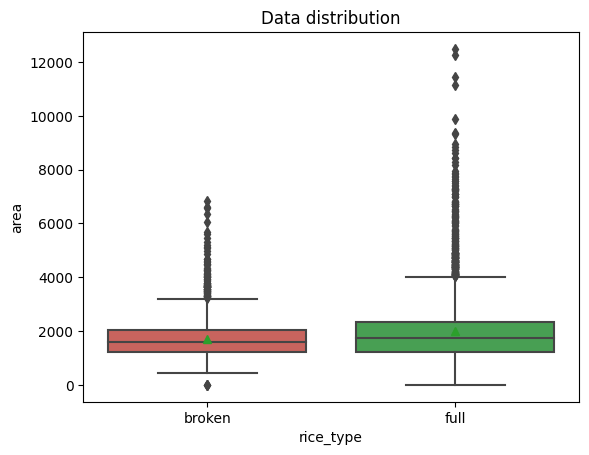

In [4]:
broken = combined[combined['rice_type'] == 'broken']
full = combined[combined['rice_type']== 'full']
sns_plot = sns.boxplot(
    data=combined,
    x = combined['rice_type'],y = combined['area'],
    palette=[sns.xkcd_rgb["pale red"], sns.xkcd_rgb["medium green"]],
    showmeans=True,
    whis=1.5
)
plt.title('Data distribution')
fig = sns_plot.get_figure()
fig.savefig("boxplot.png")
sns_plot

In [5]:
# outliers might to due error in image detection algorithm as it detects some rices together as one 

# removing outliers

In [6]:
def remove_outliers(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    return lower_bound,upper_bound
lb,ub = remove_outliers(broken['area'])
index1 = broken[broken['area']>ub].index
combined.drop(index1,inplace=True)

In [7]:
lb,ub = remove_outliers(full['area'])
index1 = full[full['area']>ub].index
combined.drop(index1,inplace=True)

<AxesSubplot: title={'center': 'Data distribution'}, xlabel='rice_type', ylabel='area'>

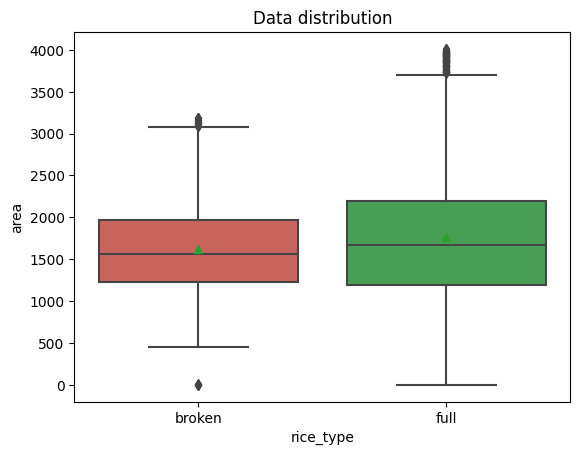

In [8]:
broken = combined[combined['rice_type'] == 'broken']
full = combined[combined['rice_type']== 'full']
sns_plot = sns.boxplot(
    data=combined,
    x = combined['rice_type'],y = combined['area'],
    palette=[sns.xkcd_rgb["pale red"], sns.xkcd_rgb["medium green"]],
    showmeans=True,
    whis=1.5
)
plt.title('Data distribution')
fig = sns_plot.get_figure()
fig.savefig("boxplot_outliers_removed.png")
sns_plot

In [9]:
combined['rice_type'].value_counts()

full      3395
broken    2272
Name: rice_type, dtype: int64

In [10]:
# we need to balanced this dataset

# data splitting

In [11]:
# need to use stratified sampling
train,test = train_test_split(combined, test_size=0.2, random_state=42)

In [12]:
train_f = train.iloc[:,0]
train_t = train.iloc[:,1]

In [13]:
test_f = test.iloc[:,0]
test_t = test.iloc[:,1]

# data encoding

In [14]:
# 0 - broken
# 1- full

# Initialize the label encoder
le = LabelEncoder()

# Encode the train target variable
# # Fit the label encoder to the target variable
le.fit(train_t)
train_t_encoded = le.transform(train_t)
train_t = train_t_encoded


# Encode the test target variable
le.fit(test_t)
test_t_encoded = le.transform(test_t)
test_t = test_t_encoded

# model buliding

1. logistic regression
2. decision tree
3. random forest

### model 1

In [15]:
#model1
# Initialize the logistic regression model
log_reg = LogisticRegression(solver='saga')

# Fit the model to the training data
log_reg.fit(train_f.to_frame(), train_t)

# Make predictions on the test data
y_pred = log_reg.predict(test_f.to_frame())


AUC for our classifier is: 0.5


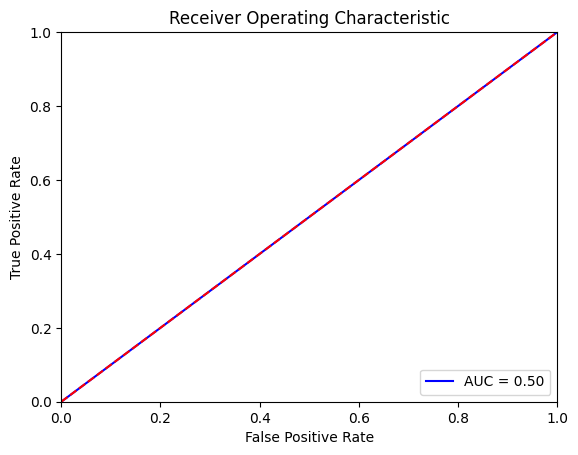

In [16]:
fpr, tpr, threshold = roc_curve(test_t, y_pred)
roc_auc = auc(fpr, tpr)

# Printing AUC
print(f"AUC for our classifier is: {roc_auc}")

# Plotting the ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### model 2

AUC for our classifier is: 0.5312455127652853


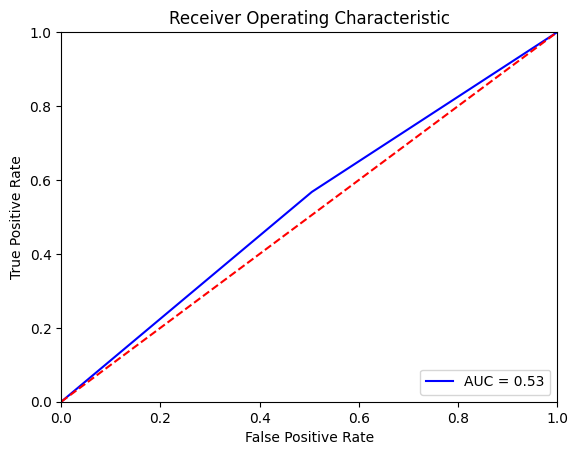

In [17]:
# Initialize the decision tree model
dt = DecisionTreeClassifier()

# Fit the model to the training data
dt.fit(train_f.to_frame(), train_t)

# Make predictions on the test data
y_pred = dt.predict(test_f.to_frame())

from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(test_t, y_pred)
roc_auc = auc(fpr, tpr)

# Printing AUC
print(f"AUC for our classifier is: {roc_auc}")

# Plotting the ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### hyperparameter tuning - model 2

In [18]:
# Define the parameter grid to search
param_grid = {'max_depth': range(1,100),
              'min_samples_split': range(1,100),
              'min_samples_leaf': range(1,100)}
# Define the custom scoring function
auc_scorer = make_scorer(roc_auc_score, greater_is_better=True)

# Initialize the RandomizedSearchCV object
random_search = RandomizedSearchCV(dt, param_distributions=param_grid, cv=5, n_jobs=-1, scoring=auc_scorer)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(train_f.to_frame(),train_t)

# Print the best parameters and the best score
print("Best parameters: {}".format(random_search.best_params_))
print("Best AUC-ROC score: {:.2f}".format(random_search.best_score_))


Best parameters: {'min_samples_split': 72, 'min_samples_leaf': 37, 'max_depth': 95}
Best AUC-ROC score: 0.53


### model 3

#### with hyperparameter tuning

In [19]:
# Define the parameter grid to search
param_dist = {'n_estimators': [10,50,200],
              'max_depth': range(1,100),
              'min_samples_split': range(1,100),
              'min_samples_leaf': range(1,100),
              'max_features': ['auto', 'sqrt', 'log2'],
              'criterion': ['gini', 'entropy'],
              'bootstrap': [True],
              'oob_score': [True, False],
              'verbose': [0, 1],
              'random_state': [42],
              'n_jobs': [-1]
             }

# Define the custom scoring function
auc_scorer = make_scorer(roc_auc_score, greater_is_better=True)

# Initialize the RandomForestClassifier 
rf = RandomForestClassifier()

# Initialize the RandomizedSearchCV object
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, cv=5, n_jobs=-1, scoring=auc_scorer,refit = True)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(train_f.to_frame(),train_t)

# Print the best parameters and the best score
print("Best parameters: {}".format(random_search.best_params_))
print("Best AUC-ROC score: {:.2f}".format(random_search.best_score_))


Best parameters: {'verbose': 1, 'random_state': 42, 'oob_score': False, 'n_jobs': -1, 'n_estimators': 10, 'min_samples_split': 9, 'min_samples_leaf': 98, 'max_features': 'log2', 'max_depth': 58, 'criterion': 'entropy', 'bootstrap': True}
Best AUC-ROC score: 0.53


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


# Exporting model

In [20]:
final_model = random_search.best_estimator_
filename = 'finalized_model.pkl'
pickle.dump(final_model, open(filename, 'wb'))

In [21]:
loaded_model = pickle.load(open(filename, 'rb'))

In [22]:
y_pred = loaded_model.predict(test_f.to_frame())

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


In [23]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(test_t, y_pred)
roc_auc = auc(fpr, tpr)
roc_auc

0.5317768013555038